In [3]:
cd ..

/home/mars/src_aiai


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tqdm
from scipy.special import iv, jv
import sparse


In [16]:
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op, NUFFT_op_1D, calculate_kaiser_bessel_coef
from src.visualisation import compare

In [6]:
from src.data import load_M51

In [7]:
from skimage.transform import radon, iradon

In [8]:
m51 = load_M51() 
m51 /= m51.max()

In [17]:
class NUFFT_op():
    """NUFFT implementation using a Kaiser-Bessel kernel for interpolation.  **changed to orthonormal scaling**
    """
    def __init__(self):
        pass
        # TODO generalise more, (pick axes, norm, etc.)
        
    def plan(self, uv, Nd, Kd, Jd, batch_size=None):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_kaiser_bessel_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        # building sparse matrix
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        # calculating scaling based on iFT of the KB kernel
        J = Jd[0] 
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        # scaling done for both axes seperately
        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1))

    def dir_op(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0], self.Nd[1])))))  # why divide on both sides?

    
    def adj_op(self, k):
        kk = self._k2kk(k)
        xx = self._kk2xx(kk)
        xx = self._unpad(xx)
        xx = np.squeeze(xx) / self.scaling
        return xx 
        # return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [18]:
def forward(x):
    rad = radon(x, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False)# N, M
    x_spokes =  op_1d.dir_op(rad.T) # takes M, N
    return rad, x_spokes

def adjoint(y, filter_name='ramp'):
    x_spokes = op_1d.adj_op(y)  #op_1d.adj_op(y) # M, N
    rec = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False, filter_name=filter_name, output_size=256)   
    return x_spokes, rec

In [19]:
x, y = np.mgrid[:256,:256]
circle_mask = (x-128)**2 + (y-128)**2 < 128**2


In [20]:
n_spokes = 37
n_lenslets = 24
n_wavelengths = 10

Nd, Kd, Jd = (256,256), (512,512), (6,6)
uv = spider_sampling(n_spokes=n_spokes, n_lenslets=n_lenslets, n_wavelengths=n_wavelengths)
op = NUFFT_op()
op.plan(uv, Nd, Kd, Jd, batch_size=n_spokes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 4712.66it/s]


In [21]:
op_1d = NUFFT_op_1D()
uv_1d = uv[:n_lenslets//2*n_wavelengths,1] # 1 spoke has 120 measurements
# uv_1d = np.concatenate((-uv[:120,1][::-1], uv[:120,1]))
op_1d.plan(uv_1d.reshape(-1,1), [256], [512], [6])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 11832.16it/s]


In [22]:
im = m51#*circle_mask
sin, ft = forward(im)
test, rec = adjoint(ft)

y = op.dir_op(im).reshape(-1, n_lenslets//2*n_wavelengths)
test2, rec2 = adjoint(y)

# 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann'
x_spokes = op_1d.adj_op(y)
rec3 = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=True, filter_name='ramp', output_size=256)   



/home/mars/.conda/envs/env/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


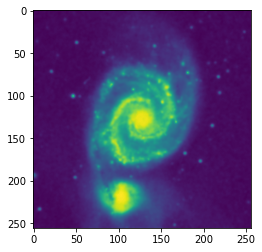

In [23]:
plt.imshow(im)

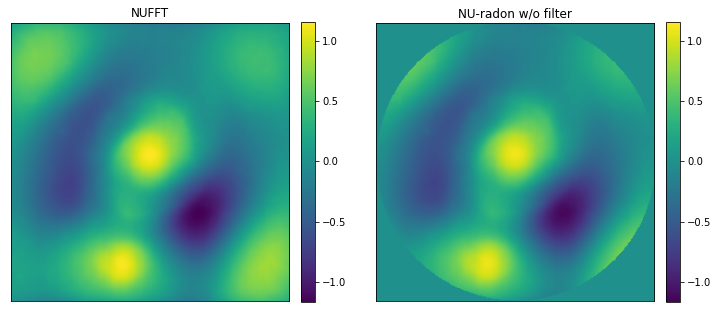

In [24]:
compare([op.adj_op(y.reshape(1,-1)).real, adjoint(y, filter_name=None)[1].real[::-1]], same_scale=True, colorbar=True, titles=["NUFFT", "NU-radon w/o filter"])

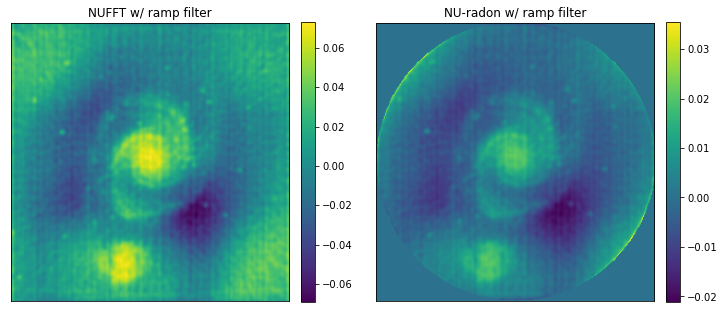

In [25]:
compare([op.adj_op(y.reshape(1,-1)*np.linalg.norm(uv, axis=1)).real, adjoint(y, filter_name='ramp')[1].real[::-1]], same_scale=False, colorbar=True, titles=["NUFFT w/ ramp filter", "NU-radon w/ ramp filter"])

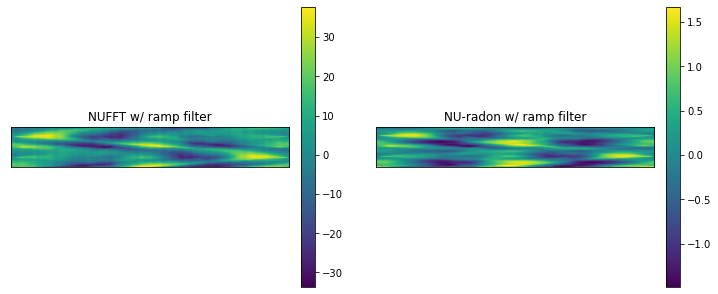

In [26]:
compare([test.real, test2.real[::-1]], same_scale=False, colorbar=True, titles=["NUFFT w/ ramp filter", "NU-radon w/ ramp filter"])

In [24]:
(rec2[::-1].real/ op.adj_op(y.reshape(-1)).real)[127, 128]

0.01846636894472216

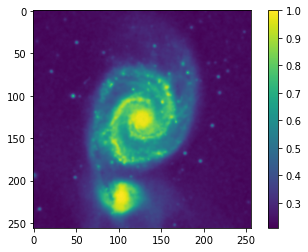

In [25]:
plt.imshow(m51)
plt.colorbar()

In [26]:
21.6/256

0.084375

In [27]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*N)**2

In [28]:
x_dirty_ndft = dft2(np.arange(-128,128), np.arange(-128,128), uv, y.reshape(-1))

  0%|                                                                                                                                                                                       | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_130590/383775551.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:17<00:00,  3.29it/s]


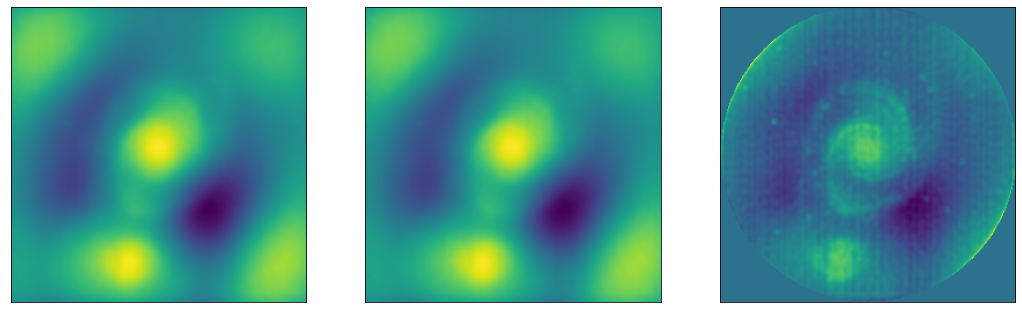

In [29]:
compare([x_dirty_ndft.real*Nd[0]*2, op.adj_op(y.reshape(1,-1)).real, adjoint(y, filter_name='ramp')[1].real[::-1]], same_scale=False)

In [67]:
r1 = x_dirty_ndft.real*Nd[0]*2 - op.adj_op(y.reshape(1,-1)).real
r2 = x_dirty_ndft.real*Nd[0]*2  - adjoint(y, filter_name=None)[1].real[::-1]

In [68]:
f'{np.sqrt(np.mean((r1*circle_mask)**2)):.4e}'

'7.9527e-05'

In [69]:
f'{np.sqrt(np.mean((r2*circle_mask)**2)):.4e}'

'2.8843e-02'